In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sdf
import re
import os
import glob

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)

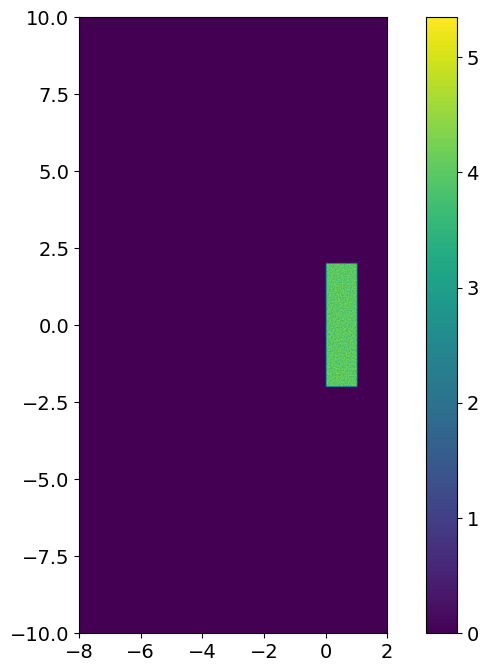

In [2]:
DATA_DIR = "14run"
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
POINTS = len(ALL_FILES)
PI = np.pi

with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data = myfile.read()


def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None


def find_angle(data):
    angle_reg = re.compile(
        "upper_theta\s+=\s+(\d{0,3})\s{0,3}\*?\s{0,3}pi\s{0,3}\/\s{0,3}(\d{0,3})"
    )
    try:
        a, b = angle_reg.search(data).groups()
    except AttributeError:
        angle_pretty = 0
        angle_rad = 0
        angle_degree = 0
        return angle_pretty, angle_degree, angle_rad

    angle_pretty = f"{a}π/{b}"
    if not a and not b:
        raise ValueError("Angle is not parsed correctly.")
    if not a:
        a = 1
    if not b:
        b = 1
    angle_rad = int(a) * PI / int(b)
    angle_degree = angle_rad * 180 / PI
    angle_degree = round(angle_degree, 1)
    return angle_pretty, angle_degree, angle_rad


angle_pretty, angle_degree, ANGLE = find_angle(data)

raw_data = sdf.read(ALL_FILES[0])
lambd = 1e-6
c = 3e8
omega = 2 * np.pi * c / lambd
n_c = omega * omega / (4 * np.pi * np.pi * 81)
X, Y = raw_data.Grid_Grid.data
X = X / lambd
Y = Y / lambd
X_MIN = X.min()
X_MAX = X.max()
Y_MIN = Y.min()
Y_MAX = Y.max()
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
EXTENT = [X_MIN, X_MAX, Y_MIN, Y_MAX]
plt.imshow(
    raw_data.Derived_Number_Density_Electron.data.T / n_c, extent=EXTENT, origin="lower"
)
# plt.scatter(x0, y0, marker="x", color="red")
plt.colorbar()

In [3]:
raw = sdf.read("0514.sdf")

In [8]:
NX = 2000
NY = 4000

In [9]:
def x_position_to_node(x):
        return int((x - X_MIN)/(X_MAX - X_MIN)*NX)

def y_position_to_node(y):
    return int((y - Y_MIN)/(Y_MAX - Y_MIN)*NY)

In [10]:
y_position_to_node(0)

1600

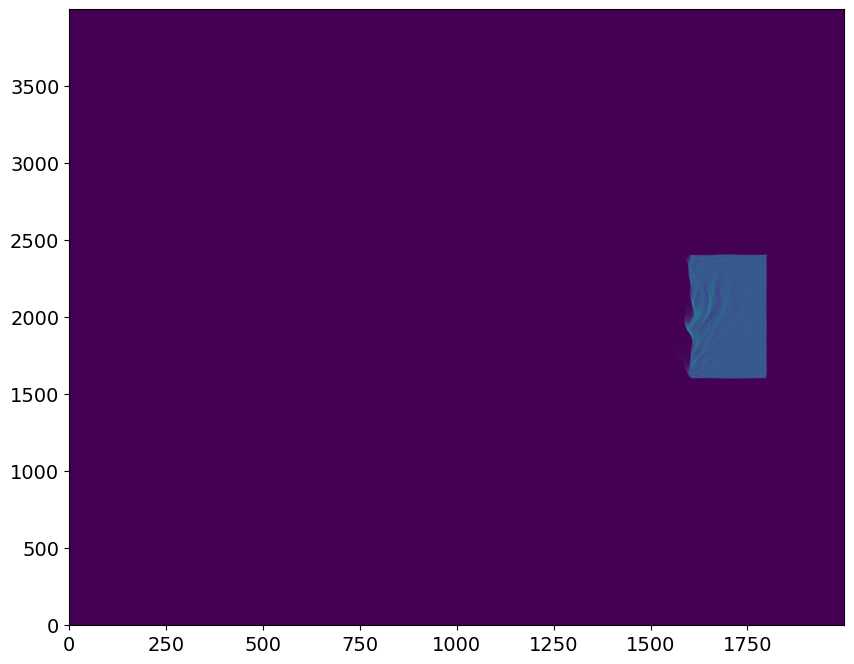

In [15]:
plt.imshow(d, origin="lower", aspect="auto")

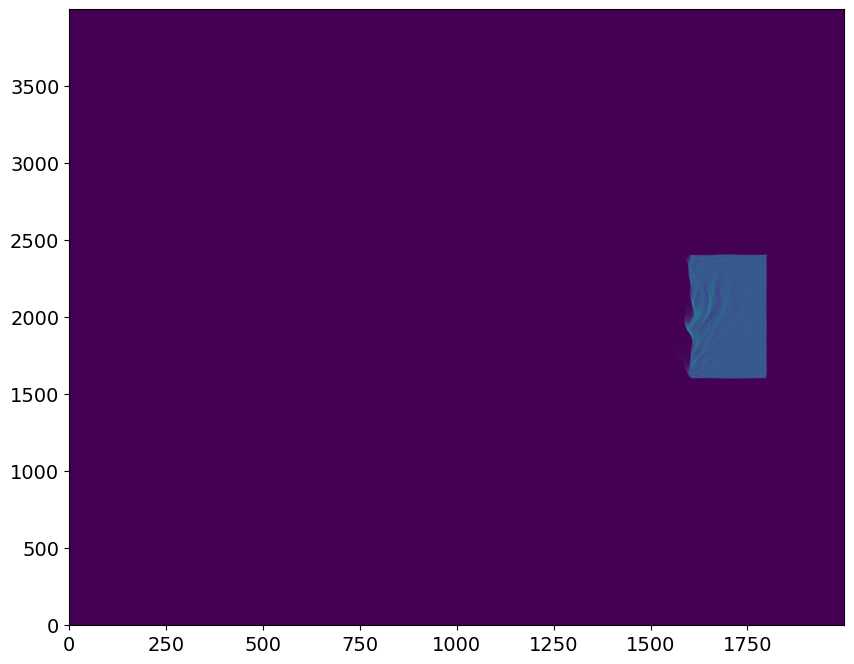

In [19]:
d = raw.Derived_Number_Density_Electron.data.T / n_c
x, y = raw.Grid_Grid.data
x = x / lambd
y = y / lambd
extent = [x.min(), x.max(), y.min(), y.max()]
plt.imshow(d, origin="lower", aspect="auto")
# plt.xlim(1560, 1640)

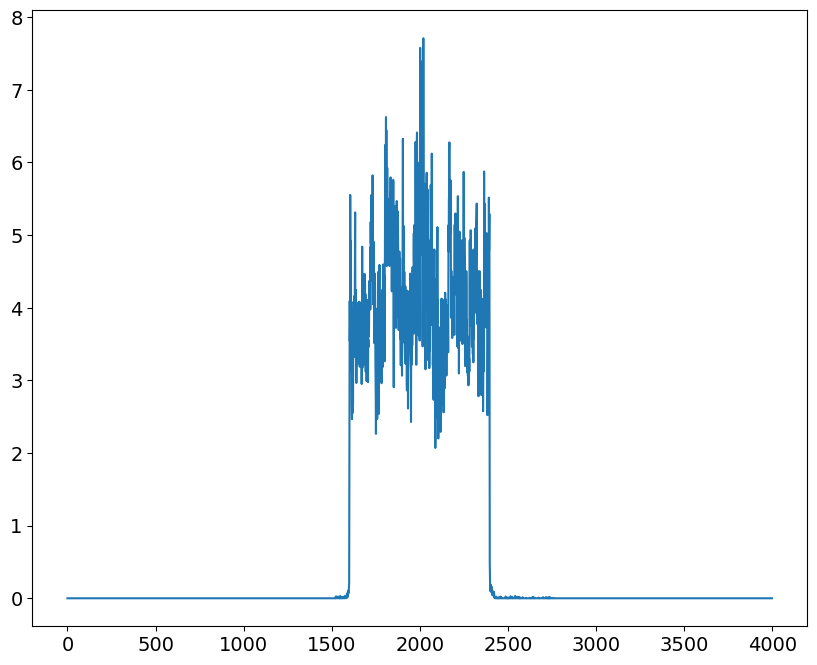

In [18]:
plt.plot(d[:, 1620])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sdf
import glob
import os
import re
from tabulate import tabulate
import tqdm
import sys


def main(
    directory,
    save_dir=None,
    show_plot=False,
):
    try:
        file_dir = os.path.dirname(os.path.realpath(__file__))
    except NameError:
        file_dir = os.getcwd()
    DATA_DIR = os.path.join(file_dir, directory)
    SAVE_DIR = os.path.join(file_dir, save_dir)

    ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
    ALL_FILES.sort()
    POINTS = len(ALL_FILES)
    print(f"Found {POINTS} files")

    main_info = {"SDF Files": POINTS}

    # Constants
    m = 9.10938356e-31
    e = 1.60217662e-19
    c = 299792458
    PI = np.pi
    epsilon = 8.85e-12
    kb = 1.38064852e-23

    # Loading Parameters
    with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
        data = myfile.read()

    def find_value(info):
        regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
        match = regex.search(data)
        if match:
            return float(match.group(1))
        else:
            return None

    def find_angle(data):
        angle_reg = re.compile(
            "upper_theta\s+=\s+(\d{0,3})\s{0,3}\*?\s{0,3}pi\s{0,3}\/\s{0,3}(\d{0,3})"
        )
        try:
            a, b = angle_reg.search(data).groups()
        except AttributeError:
            angle_pretty = 0
            angle_rad = 0
            angle_degree = 0
            return angle_pretty, angle_degree, angle_rad

        angle_pretty = f"{a}π/{b}"
        if not a and not b:
            raise ValueError("Angle is not parsed correctly.")
        if not a:
            a = 1
        if not b:
            b = 1
        angle_rad = int(a) * PI / int(b)
        angle_degree = angle_rad * 180 / PI
        angle_degree = round(angle_degree, 1)
        return angle_pretty, angle_degree, angle_rad

    raw_data = sdf.read(ALL_FILES[0])

    LAMBD = find_value("lambda0") * 1e-6
    X, Y = raw_data.Grid_Grid.data
    X = X / LAMBD
    Y = Y / LAMBD
    X_MIN = X.min()
    X_MAX = X.max()
    Y_MIN = Y.min()
    Y_MAX = Y.max()
    NX = int(find_value("cells_x"))
    NY = int(find_value("cells_y"))
    EXTENT = [X_MIN, X_MAX, Y_MIN, Y_MAX]
    LAS_TIME = int(find_value("las_time"))
    T_MAX = int(find_value("simulation_end"))
    DT = find_value("snapshot_freq") * 1e-15
    A0 = find_value("a0")
    FACTOR = int(find_value("factor"))
    NX = int(find_value("cells_x"))
    NY = int(find_value("cells_y"))
    TEMPERATURE = find_value("temp")
    angle_pretty, angle_degree, ANGLE = find_angle(data)

    main_info["Lambda"] = LAMBD
    main_info["Extent"] = EXTENT
    main_info["Cells in X"] = NX
    main_info["Cells in Y"] = NY
    main_info["Laser Time"] = LAS_TIME
    main_info["Max Time"] = T_MAX
    main_info["Delta T"] = DT
    main_info["A0"] = A0
    main_info["Density Factor"] = FACTOR
    main_info["Angle in Degree"] = angle_degree
    main_info["Angle"] = angle_pretty

    # Calculating Parameters
    omega0 = 2 * PI * c / LAMBD
    tau = 2 * PI / omega0
    nc = epsilon * m * omega0**2 / e**2
    Er = m * omega0 * c / e
    n0 = FACTOR * nc
    LAS_TIME = LAS_TIME * tau
    lambdaD = np.sqrt(epsilon * kb * TEMPERATURE / (n0 * e**2))
    vth = np.sqrt(kb * TEMPERATURE / m)
    f_max = 1 / (2 * DT)
    omega_max = 2 * PI * f_max
    omega_max_natural = omega_max / omega0
    calculated_info = {
        "Omega0": omega0,
        "Tau": tau,
        "Critical Density": nc,
        "Electric Field": Er,
        "Density": n0,
        "Laser Time": LAS_TIME,
        "Debye Length": lambdaD,
        "Thermal Velocity": vth,
        "Max Resolvable Frequency": f_max,
        "Max Resolvable Omega": omega_max_natural,
    }

    table_main = tabulate(main_info.items(), headers=["Parameter", "Value"])
    table_calculated = tabulate(calculated_info.items(), headers=["Parameter", "Value"])
    print(table_main)
    print()
    print()
    print(table_calculated)

    def x_position_to_node(x):
        return int((x - X_MIN) / (X_MAX - X_MIN) * NX)

    def y_position_to_node(y):
        return int((y - Y_MIN) / (Y_MAX - Y_MIN) * NY)

    x = 0
    y1 = 0
    y2 = 1
    y3 = -1

    node_x = x_position_to_node(x)
    node_y1 = y_position_to_node(y1)
    node_y2 = y_position_to_node(y2)
    node_y3 = y_position_to_node(y3)

    p1 = (node_x, node_y1)
    p2 = (node_x, node_y2)
    p3 = (node_x, node_y3)

    D1 = np.zeros(POINTS)
    D2 = np.zeros(POINTS)
    D3 = np.zeros(POINTS)

    for i in tqdm.tqdm(
        range(POINTS),
        desc="Calculating fields",
        unit="files",
        file=sys.stdout,
    ):
        raw_data = sdf.read(ALL_FILES[i])
        density = raw_data.Derived_Number_Density_electron.data
        D1[i] = density[p1]
        D2[i] = density[p2]
        D3[i] = density[p3]

    def plot_fft_one(ax, data, plot_lines):
        data_fft = np.fft.fft(data)
        data_fft = np.fft.fftshift(data_fft)
        data_fft = np.abs(data_fft)
        data_fft = data_fft / (data_fft.max() + 1e-10)

        ax.plot(omega, data_fft, color="black", linewidth=0.5)
        ax.set_yscale("log")
        ax.set_xlim(
            0,
        )
        ax.set_xlabel("Frequency (ω)")
        ax.set_ylabel("Amplitude")
        xticks = np.arange(1, int(omega_max_natural) + 3, 2)
        ax.set_xticks(xticks)
        if plot_lines:
            for x in xticks:
                ax.axvline(x, color="k", alpha=0.7, linewidth=0.5)

    def get_image_name(name):
        if name is not None:
            fig_name = os.path.join(SAVE_DIR, name)
            if "." not in fig_name:
                fig_name += ".png"
        else:
            fig_name = None
        return fig_name

    def plot_ffts(fig_name=None):
        fig, ax = plt.subplots(3, 1, figsize=(5, 15))
        plot_fft_one(ax[0], D1, True)
        plot_fft_one(ax[1], D2, True)
        plot_fft_one(ax[2], D3, True)
        ax[0].set_title(f"FFT of Density at {p1}")
        ax[1].set_title(f"FFT of Density at {p2}")
        ax[2].set_title(f"FFT of Density at {p3}")
        fig.tight_layout()
        if fig_name:
            fig_name = get_image_name(fig_name)
            fig.savefig(fig_name, dpi=100)
        if show_plot:
            plt.show()

    fig_name = f"{dir}_density_fft"
    plot_ffts(fig_name)